# UK Road Safety: Traffic Accidents and Vehicles - Model Definition
## Detailed dataset of road accidents and involved vehicles in the UK (2005-2016)
Source:
<u>https://www.kaggle.com/tsiaras/uk-road-safety-accidents-and-vehicles#Accident_Information.csv </u>
    



# Standard imports
+useful figure save function

In [1]:
# The code was removed by Watson Studio for sharing.

In [3]:
import random as rnd
import numpy as np
import pandas as pd
import sys
import datetime
from matplotlib import pyplot as plt
from collections import Counter
import logging
import time
import math


#prevents intrusive spark debug notificaitions
logging.getLogger("py4j").setLevel(logging.ERROR)
plt.style.use('seaborn-whitegrid')
cmap=plt.get_cmap('Pastel2')
#cmap=plt.get_cmap('tab20c')

mypath_ = !pwd

def save_fig(fig_id, fig_txt, tight_layout=True, fig_extension="png", resolution=300):
    #generic function to save images to file
    filename =  mypath_[0]+'/img/' + fig_txt + "." + fig_extension
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    fig_id.savefig(filename, format=fig_extension, dpi=resolution, bbox_inches='tight')
    file_data=open(filename, 'rb')
    project.save_data(data=file_data.read(),file_name=fig_txt+'.png',overwrite=True)
    file_data.close() 


# Load data from Parquet files
Load the previously transformed dataset<br>
Allow for loading a sample for testing

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

rdd_accidents = spark.read.load("accidents_tr.parquet")

#Uncomment to select subset of the data
######################## UNCOMMENT FOR TESTING ##########################
#rdd_accidents = rdd_accidents.sample(withReplacement=False, fraction=0.1)
#########################################################################


rdd_accidents.head()
rdd_accidents.createOrReplaceTempView("accidents")
rdd_accidents.printSchema()
print("number of records: {:d}".format(rdd_accidents.count()))


root
 |-- Accident_Index: string (nullable = true)
 |-- 1st_Road_Class: string (nullable = true)
 |-- 1st_Road_Number: string (nullable = true)
 |-- 2nd_Road_Class: string (nullable = true)
 |-- 2nd_Road_Number: string (nullable = true)
 |-- Accident_Severity: string (nullable = true)
 |-- Carriageway_Hazards: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Day_of_Week: string (nullable = true)
 |-- Did_Police_Officer_Attend_Scene_of_Accident: string (nullable = true)
 |-- Junction_Control: string (nullable = true)
 |-- Junction_Detail: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Light_Conditions: string (nullable = true)
 |-- Local_Authority_District: string (nullable = true)
 |-- Local_Authority_Highway: string (nullable = true)
 |-- Location_Easting_OSGR: integer (nullable = true)
 |-- Location_Northing_OSGR: integer (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Number_of_Casualties: integer (nullable = true)
 |-- Number_

## Load Packages

In [5]:
from pyspark.sql import functions as F 
from pyspark.sql.functions import *
from pyspark.sql.functions import col, isnan, when, trim
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer, IndexToString, VectorIndexer
from pyspark.ml.feature import VectorAssembler, MinMaxScaler, OneHotEncoder
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit, CrossValidator
from pyspark.ml.evaluation import Evaluator, MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.evaluation import RegressionEvaluator


#from pyspark.mllib.evaluation import BinaryClassificationMetrics

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

rnd_seed=42 #for reproductibility

# Use case: predict accident severity at each output area (LSOA) given datetime and driving conditions
<b>We will be looking at one Police Force to start with and only retain a few features based on our use case:</b><br>
<br>
<em>Given date, time, weather, light and road conditions, predict accident severity within the operating geographic area of a police force</em> <br>
<br>
<b>The deliverable is a tool that should faciliate ressource allocation to mitigate the probability of serious accidents given current driving conditions</b>

## Loading and encoding functions
Some not needed (particularly since adding centroids was later on added to the feature engineering notebook)<br>
<b>The main takeaway is that the raw data is aggregated according to each categorical data, <br>
then counts of 'Slight' and 'Serious' accidents are performed as well as the ratio of 'Serious'/('Slight'+'Serious').<br>
This ratio ('Severety_Pct) is our reponse variable. The machine learning task is therefore a regression model to predict this ratio.<br>
Later on we aggregate this informatio at LSOA level - to be displayed on a map on the final deliverable</b>

In [6]:
#some global variables

retained_features=[
    'Accident_Severity',
    'LSOA_of_Accident_Location',
    'Police_Force',
    'Latitude',
    'Longitude',
    'Weather_Conditions',
    'Light_Conditions',
    'Road_Surface_Conditions',
    'Day_of_Week',
    'Hour',
    'Week',
    'Peak_or_OffPeak']

features={
    'response':'Accident_Severity',
    'cat_pred': ['Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions',\
            'Day_of_Week', 'LSOA_of_Accident_Location', 'Peak_or_OffPeak']}

data_group={
    'name': "Police_Force",
    'item': "City of London"}



def to_null(c):
        #function to discard NUL NA and empty records
        from pyspark.sql.functions import col, isnan, when, trim
        return when(~(col(c).isNull() | isnan(col(c)) | (trim(col(c)) == "")), col(c))
    

    
def load_data(group=data_group, feats=retained_features):
#load data from one group into RDD selecting only retained features and create view
    sql_query= '''SELECT {} FROM {} WHERE {}={}'''
    try:
        if group['name']=='All':
            rdd_data = spark.sql("SELECT {} from accidents".format(', '.join(feats)))
        else:
            rdd_data = spark.sql(sql_query.format(', '.join(feats), "accidents", group['name'], "'"+group['item']+"'"))
        #remove any null or empty entries
        rdd_data = rdd_data.select([to_null(c).alias(c) for c in rdd_data.columns]).na.drop()
        print(rdd_data.head())
        rdd_data.createOrReplaceTempView("data")
        nb_slight  = spark.sql("SELECT COUNT(Accident_Severity) FROM data WHERE Accident_Severity='Slight'").collect()[0][0]
        nb_severe  = spark.sql("SELECT COUNT(Accident_Severity) FROM data WHERE Accident_Severity='Serious'").collect()[0][0]
        print("nb Slight:{:d}, nb Serious:{:d}, %Slight: {:.1f}%".format(nb_slight, nb_severe, 100*nb_slight/(nb_slight+nb_severe)))
        return rdd_data
    except:
        print("{} not found in {}".format(group['item'], group['name']))
        return None      
                 
             
def summarize_data_by_lsoa(rdd_data, feats = retained_features[1:]):
    #summarize data by output area
    rdd_data.createOrReplaceTempView("data")
    severe_col = 'Accident_Severity'
    acc_type = "Slight"
    lsoa = 'LSOA_of_Accident_Location'
    sql_query = '''
        SELECT {0},
        COUNT(CASE WHEN {1}  = '{2}' THEN {3} END) AS Slight, 
        COUNT(CASE WHEN {1} != '{2}' THEN {3} END) AS Serious 
        FROM {4} GROUP BY {5}'''
    new_rdd = spark.sql(sql_query.format(', '.join(feats), severe_col, acc_type, severe_col, "data", ', '.join(feats)))
    new_rdd = new_rdd.withColumn('Severity_Pct', (new_rdd['Serious']/(new_rdd['Slight']+new_rdd['Serious'])).cast('double'))
    try:
        new_rdd.select([to_null(c).alias(c) for c in new_rdd.columns]).na.drop()
    except:
        print("Standard NA.drop only")
        new_rdd.na.drop()
    return new_rdd


def load_rdd_data_and_string_encode(group=data_group, features=features):
    #Load data and string-encode all categorical variables
    rdd_data = load_data(group=group)
    rdd_data, columns_index = string_encode(rdd_data, features['cat_pred'])
    new_features={}
    new_features['cat_pred'] = columns_index[:-1]
    new_features['response'] = columns_index[-1]
    return rdd_data, new_features

def load_and_split_data(group=data_group, features=features):
    #generic load and split
    rdd_data, new_features = load_rdd_data(group, features)
    #Split train/test
    rdd_train, rdd_test = rdd_data.randomSplit([0.8, 0.2], seed=rnd_seed)
    return rdd_train, rdd_test, new_features


def load_and_split_data_with_centroids(group=data_group, features=features):
    #load add centroid data and split (no longer needed in next iteration)
    rdd_data, new_features = load_rdd_data(group, features)
    lsoa_data = spark.sql("SELECT LSOA_of_Accident_Location, COUNT(LSOA_of_Accident_Location) As Accident_Count,\
          PERCENTILE(Latitude, 0.5) AS Centroid_Latitude, PERCENTILE(Longitude, 0.5) AS Centroid_Longitude \
          FROM accidents GROUP BY LSOA_of_Accident_Location")
    rdd_data = rdd_data.join(lsoa_data, rdd_data.LSOA_of_Accident_Location == lsoa_data.LSOA_of_Accident_Location)\
    .drop(lsoa_data.LSOA_of_Accident_Location).drop(lsoa_data.Accident_Count)
    #remove null values
    rdd_data = rdd_data.select([to_null(c).alias(c) for c in rdd_data.columns]).na.drop()
    #add centroids in feature list
    new_features['ord_pred'] = ['Centroid_Latitude', 'Centroid_Longitude']
    #remove LSOA_of_Accident_Location from feature list
    if 'LSOA_of_Accident_Location' in new_features['cat_pred']: new_features['cat_pred'].remove('LSOA_of_Accident_Location')
    rdd_train, rdd_test = rdd_data.randomSplit([0.8, 0.2], seed=rnd_seed)
    return rdd_train, rdd_test, new_features

    
    
def string_encode(rdd_data, columns):
    #string encode categorical variables using a list of stacked pipelines
    indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(rdd_data) for column in columns]
    index_pipeline = Pipeline(stages=indexers)
    columns_index = [x+'_index' for x in columns]
    return index_pipeline.fit(rdd_data).transform(rdd_data), columns_index


def cyc_encode(rdd_data, columns, period):
    #encode cyclical variables like hour or week using sin/cos 
    #(not used after only considering peak/off_peak hours given data sparsity)
    from math import pi
    for i, column in enumerate(columns):
        udf_sin = udf(lambda x: math.sin(2.0*pi*float(x)/period[i]), DoubleType())
        udf_cos = udf(lambda x: math.cos(2.0*pi*float(x)/period[i]), DoubleType())
        rdd_data = rdd_data.withColumn("sin_"+column, udf_sin(col))
        rdd_data = rdd_data.withColumn("cos_"+column, udf_cos(col))
        columns_cyc = [cyc+x for cyc in ['sin_', 'cos_'] for x in columns]
    return rdd_data, columns_cyc    
        

In [7]:
#Display LSOA aggregated data and some aggragated statistics
rdd_data = load_data(feats=retained_features, group=data_group)
print("# of records {:d}". format(rdd_data.count()))
print("Summary by LSOA")
summarize_data_by_lsoa(rdd_data, feats = features['cat_pred']).toPandas().head()
del rdd_data

Row(Accident_Severity='Serious', LSOA_of_Accident_Location='E01000004', Police_Force='City of London', Latitude=51.509528, Longitude=-0.079251, Weather_Conditions='Fine no high winds', Light_Conditions='Daylight', Road_Surface_Conditions='Wet or damp', Day_of_Week='Tuesday', Hour=6, Week=1, Peak_or_OffPeak='OffPeak')
nb Slight:3481, nb Serious:589, %Slight: 85.5%
# of records 4070
Summary by LSOA


<b>Dataset is imbalanced: 85.5% of instances are 'Slight' accidents.<br>
The average of 'Severity_Pct' is around 15%</b>

In [8]:
#Calculate aggregated Police force data with computed GPS centroids
#This allows us to see the size of the data for each police force.
#we choose "City of London as it has a smaller dataset yet is relatively characteristic of the rest of the data"
sql_query = '''
    SELECT 
    Police_Force, 
    COUNT(Police_Force) As Accident_Count, 
    COUNT(DISTINCT(LSOA_of_Accident_Location)) AS Nb_of_LSOAS, 
    COUNT(Police_Force)/COUNT(DISTINCT(LSOA_of_Accident_Location)) AS Avge_Acc_per_LSOA,
    PERCENTILE(Latitude, 0.5) AS Centroid_Latitude, 
    PERCENTILE(Longitude, 0.5) AS Centroid_Longitude 
    FROM accidents GROUP BY Police_Force'''

police_force_data = spark.sql(sql_query)
police_force_data.toPandas()


,Police_Force,Accident_Count,Nb_of_LSOAS,Avge_Acc_per_LSOA,Centroid_Latitude,Centroid_Longitude
0,Thames Valley,70832,1469,48.217835,51.630713,-0.845010
1,Gwent,9794,380,25.773684,51.639377,-3.034203
2,Hampshire,58687,1259,46.613979,50.911118,-1.211942
3,Staffordshire,38431,711,54.052039,52.843315,-2.105602
4,Gloucestershire,14476,378,38.296296,51.856355,-2.199352
5,Nottinghamshire,35942,718,50.058496,53.001888,-1.155156
6,North Yorkshire,26844,502,53.474104,54.018132,-1.217075
7,Surrey,48852,746,65.485255,51.305362,-0.472989
8,Cumbria,17363,324,53.589506,54.566457,-2.993077
9,Cleveland,12183,385,31.644156,54.570228,-1.236459


,LSOA_of_Accident_Location,Accident_Count,Centroid_Latitude,Centroid_Longitude
0,E01000078,60,51.551703,0.131513
1,E01000138,106,51.562226,-0.204418
2,E01000622,7,51.565717,-0.250044
3,E01000781,46,51.428815,0.053315
4,E01000838,28,51.372502,-0.001649


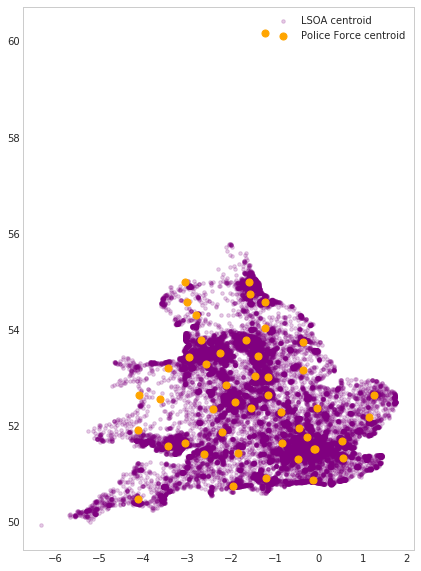

In [9]:
#Calculate aggregated LSOA data with computed GPS centroids
#Just to display the next graph and sanity check
sql_query = '''
    SELECT 
    LSOA_of_Accident_Location, COUNT(LSOA_of_Accident_Location) As Accident_Count,
    PERCENTILE(Latitude, 0.5) AS Centroid_Latitude, 
    PERCENTILE(Longitude, 0.5) AS Centroid_Longitude 
    FROM accidents 
    GROUP BY LSOA_of_Accident_Location'''
lsoa_data = spark.sql(sql_query)
from matplotlib import pyplot as plt
df1 = lsoa_data.toPandas()
df2 = police_force_data.toPandas()
fig, ax = plt.subplots(figsize=(7,10))
ax.scatter(df1.Centroid_Longitude, df1.Centroid_Latitude, marker='.', alpha=0.2, s=50, c='purple', label='LSOA centroid')
ax.scatter(df2.Centroid_Longitude, df2.Centroid_Latitude, marker='.', alpha=1.0, s=200, c='orange', label='Police Force centroid')
l = ax.legend()
ax.grid(False)

lsoa_data.toPandas().head()



# Gradient Boosted Trees

In [10]:
def load_and_split_summary_data(group=data_group, features=features):
    #load data and split into train/test rdds to be consumed by the gbt models
    start_time = time.time()
    rdd_data = load_data(group=group)
    #Split train/test
    rdd_train, rdd_test = rdd_data.randomSplit([0.8, 0.2], seed=rnd_seed)
    rdd_train = summarize_data_by_lsoa(rdd_train, feats = features['cat_pred'])
    rdd_test = summarize_data_by_lsoa(rdd_test, feats = features['cat_pred'])
    new_features={}
    new_features['response'] = 'Severity_Pct'
    new_features['cat_pred'] = features['cat_pred']
    print("loading completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return rdd_train, rdd_test, new_features


def create_and_train_gbt_model(features=features):
    #instantiate pipeline and train the model
    #categorical data is simply converted into indexes - the gbt models does not need one-hot encoding 
    start_time = time.time()
    new_features = {}
    new_features['response'] = features['response']
    #string_encode categorical data using a list of indexers, one for each categorical data
    #ensureing the encoding is done on train+test set to have consistent encoding accross both sets
    rdd_data = rdd_train.unionAll(rdd_test)
    indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(rdd_data) for column in features['cat_pred']]
    new_features['cat_pred'] = [x+'_index' for x in features['cat_pred']]
    #Vectorise the inputs
    vectorAssembler = VectorAssembler(inputCols=new_features['cat_pred'], outputCol="features")
    #Instatiate classifier
    gbt = GBTRegressor(labelCol=new_features['response'], featuresCol="features",
                        maxIter=30, maxDepth=6, maxBins=100)
    #Create pipeline
    pipeline = Pipeline(stages=indexers + [vectorAssembler, gbt])
    #Fit Model
    model_gbt = pipeline.fit(rdd_train)
    print("training completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return new_features, pipeline, model_gbt


def evaluate_reg_model(model, rdd, set_name, response=features["response"]):
    #Calculate root mean squared error as a performance measures
    start_time = time.time()
    evaluator = RegressionEvaluator(labelCol=response, predictionCol="prediction", metricName="rmse")
    predY = model.transform(rdd)
    rmse = evaluator.evaluate(predY)
    print("Root Mean Squared Error (RMSE) on {} data = {:.2f}".format(set_name, rmse)) 
    print("evaluation completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return predY


def display_results_graphs(pred_train, pred_test):
    #Display the actual Sererity_Pct for each instance (sorted by increasing order) and compare to predictions
    #for both the train and test set
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    df1 = pred_train.toPandas().sort_values('Severity_Pct')
    df1.plot(y='Severity_Pct', ax=ax1, use_index=False, c='k', linewidth=2)
    df1.plot(y='prediction', ax=ax1, use_index=False, c='b', alpha=0.7)
    ax1.set_title("Train set", fontweight='bold')
    ax1.set_ylim(-.1, 1.2)
    ax1.set_xlabel("summary instance")
    ax1.set_ylabel("severity ratio")
    df2 = pred_test.toPandas().sort_values('Severity_Pct')
    df2.plot(y='Severity_Pct', ax=ax2, use_index=False, c='k', linewidth=2)
    df2.plot(y='prediction', ax=ax2, use_index=False,c='r', alpha=0.7)
    ax2.set_title("Test set", fontweight='bold')
    ax2.set_ylim(-.1, 1.2)
    ax2.set_xlabel("summary instance")
    ax2.set_ylabel("severity ratio")    
    print("train set size={:d}, test set size={:d}".format(len(df1), len(df2)))
    return


def display_agg_results_graphs(pred_train, pred_test):
    #Display the actual Sererity_Pct for each instance (sorted by increasing order) and compare to predictions
    #for both the train and test set
    #But this time AGGREGATED by LSOA - this will be the actual deliverable 
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    try:
        df1 = pred_train.toPandas().groupby(['LSOA_of_Accident_Location'])['Severity_Pct', 'prediction']\
                    .mean().reset_index().sort_values('Severity_Pct')
        df2 = pred_test.toPandas().groupby(['LSOA_of_Accident_Location'])['Severity_Pct', 'prediction']\
                    .mean().reset_index().sort_values('Severity_Pct')
    except:
        #normalised dataset
        df1 = pred_train.toPandas().groupby(['Centroid_Latitude','Centroid_Longitude'])['Severity_Pct', 'prediction']\
                    .mean().reset_index().sort_values('Severity_Pct')
        df2 = pred_test.toPandas().groupby(['Centroid_Latitude','Centroid_Longitude'])['Severity_Pct', 'prediction']\
                    .mean().reset_index().sort_values('Severity_Pct')
    bars = ax1.bar(range(len(df1)),df1.prediction, color='b', alpha=0.5, label='prediction')
    bars = ax1.bar(range(len(df1)),df1.Severity_Pct, color='none', edgecolor='k', lw=1, label='actual')
    ax1.xaxis.grid(False)
    ax1.set_xticks([])
    ax1.set_ylim(-.1, 1.2)
    ax1.set_xlabel("LSOA")
    ax1.set_ylabel("Avge severity ratio")
    ax1.set_title("Train set", fontweight='bold')
    l=ax1.legend()
    for bar in bars:
        bar.set_edgecolor("k")
        bar.set_linewidth(1)

    bars = ax2.bar(range(len(df2)),df2.prediction, color='r', alpha=0.5, label='prediction')
    bars = ax2.bar(range(len(df2)),df2.Severity_Pct, color='none', edgecolor='k', lw=1, label='actual')
    ax2.xaxis.grid(False)
    ax2.set_xticks([])
    ax2.set_ylim(-.1, 1.2)
    ax2.set_xlabel("LSOA")
    ax2.set_ylabel("Avge severity ratio")
    l=ax2.legend()
    ax2.set_title("Test set", fontweight='bold')
    for bar in bars:
        bar.set_edgecolor("k")
        bar.set_linewidth(1)
    return


## Initial results

Row(Accident_Severity='Serious', LSOA_of_Accident_Location='E01000004', Police_Force='City of London', Latitude=51.509528, Longitude=-0.079251, Weather_Conditions='Fine no high winds', Light_Conditions='Daylight', Road_Surface_Conditions='Wet or damp', Day_of_Week='Tuesday', Hour=6, Week=1, Peak_or_OffPeak='OffPeak')
nb Slight:3481, nb Serious:589, %Slight: 85.5%
loading completed  - Processing time: 12 secs
training completed  - Processing time: 223 secs
Root Mean Squared Error (RMSE) on train data = 0.11
evaluation completed  - Processing time: 1 secs
Root Mean Squared Error (RMSE) on test data = 0.36
evaluation completed  - Processing time: 1 secs
train set size=481, test set size=220


DataFrame[Weather_Conditions: string, Light_Conditions: string, Road_Surface_Conditions: string, Day_of_Week: string, LSOA_of_Accident_Location: string, Peak_or_OffPeak: string, Slight: bigint, Serious: bigint, Severity_Pct: double]

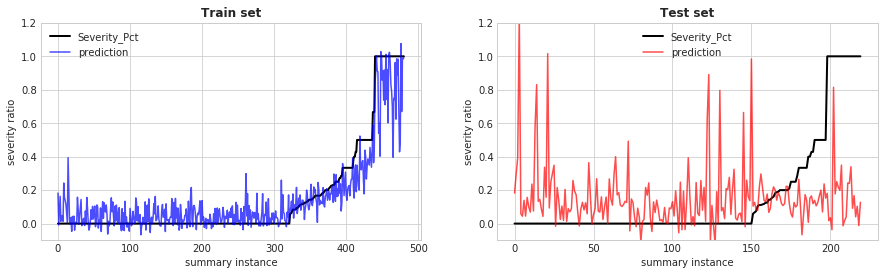

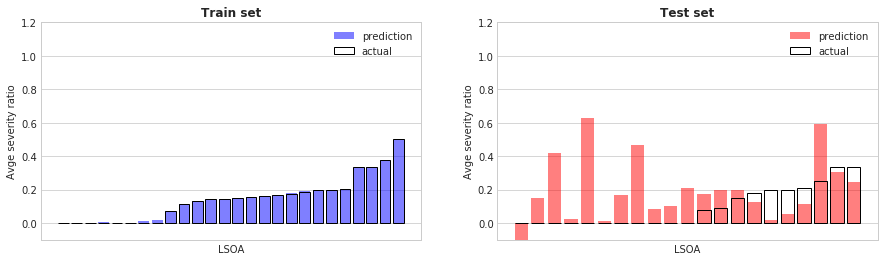

In [304]:
features={
    'response':'Severity_Pct',
    'cat_pred': ['Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions',\
            'Day_of_Week', 'LSOA_of_Accident_Location', 'Peak_or_OffPeak']}

data_group={
    'name': "Police_Force",
    'item': "City of London"}

rdd_train, rdd_test, ml_feats= load_and_split_summary_data(data_group, features)
rdd_train.cache()
rdd_test.cache()
ml_feats, pipeline, model_gbt = create_and_train_gbt_model(ml_feats)
pred_train = evaluate_reg_model(model_gbt, rdd_train, "train", response=ml_feats["response"])
pred_test = evaluate_reg_model(model_gbt, rdd_test, "test", response=ml_feats["response"])
display_results_graphs(pred_train, pred_test)
display_agg_results_graphs(pred_train, pred_test)
rdd_train.unpersist()
rdd_test.unpersist()

<b>The average proportion of accident severity across all the LSOAs is around 15%<br>
On this dataset it appears that instances are quite binary: most ratios are either 0 or 1, with little in-between<br>
Aggreated at LSOA level the results are smoother</b>


## Additional feature transformation: Replace categorical LSOA with continuous Lat/Lon Centroids - normalised

In [11]:
def one_hot_encode(rdd_data, columns):
    #one_hot_encode categorical variables
    for column in columns:
        try:
            rdd_data = OneHotEncoder(inputCol=column, outputCol=column+"_vec").transform(rdd_data)
        except:
            print("One_hot encoding already performed for ", column)
    columns_vec = [x+'_vec' for x in columns]
    return rdd_data, columns_vec


def load_one_hot_and_split_data_with_centroids(group=data_group, features=features):
    #Because of the vectorisation of features required by spark ML,
    #we have to either normalise all features or none 
    #This means that we now have to explicitly one-hot encode the categorical features
    #The encoding has to be done before the train/test split to ensure that it is consistent across both sets
    #The fianl step is aggregating the data by lsoa and compute our response feature
    start_time = time.time()
    rdd_data = load_data(group=group)
    new_features={}
    new_features['response'] = 'Severity_Pct'
    new_features['cat_pred'] = features['cat_pred']
    #Add centroid data
    sql_query = ''' 
        SELECT 
        LSOA_of_Accident_Location, COUNT(LSOA_of_Accident_Location) As Accident_Count,
        PERCENTILE(Latitude, 0.5) AS Centroid_Latitude, 
        PERCENTILE(Longitude, 0.5) AS Centroid_Longitude 
        FROM accidents 
        GROUP BY LSOA_of_Accident_Location'''
    lsoa_data = spark.sql(sql_query)
    rdd_data = rdd_data.join(lsoa_data, rdd_data.LSOA_of_Accident_Location == lsoa_data.LSOA_of_Accident_Location)\
    .drop(lsoa_data.LSOA_of_Accident_Location).drop(lsoa_data.Accident_Count)
    #remove null values
    rdd_data = rdd_data.select([to_null(c).alias(c) for c in rdd_data.columns]).na.drop()
    #add centroids in feature list
    new_features['ord_pred'] = ['Centroid_Latitude', 'Centroid_Longitude']
    #remove LSOA_of_Accident_Location from feature list
    if 'LSOA_of_Accident_Location' in new_features['cat_pred']: new_features['cat_pred'].remove('LSOA_of_Accident_Location')
    #one_one encode categorical data
    rdd_data, new_features['cat_pred'] = string_encode(rdd_data, new_features['cat_pred'])
    rdd_data, new_features['cat_pred_vec'] = one_hot_encode(rdd_data, new_features['cat_pred'])
    #Split train/test
    rdd_train, rdd_test = rdd_data.randomSplit([0.8, 0.2], seed=rnd_seed)
    rdd_train = summarize_data_by_lsoa(rdd_train, feats = new_features['cat_pred_vec']+new_features['ord_pred'])
    rdd_test = summarize_data_by_lsoa(rdd_test, feats = new_features['cat_pred_vec']+new_features['ord_pred'])
    print("loading completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return rdd_train, rdd_test, new_features



def create_and_train_gbt_model_normalised(rdd_train, features=features):
    #instantiate pipeline and train the model
    start_time = time.time()
    new_features = features
    #Vectorise the inputs
    vectorAssembler = VectorAssembler(inputCols=new_features['cat_pred_vec']+new_features['ord_pred'], outputCol="features")
    #Normalise all features
    scaler = MinMaxScaler(inputCol="features", outputCol="scaledFeatures")
    #Instatiate classifier
    gbt = GBTRegressor(labelCol=new_features['response'], featuresCol="scaledFeatures",
                        maxIter=30, maxDepth=6, maxBins=100)
    #Create pipeline
    pipeline = Pipeline(stages=[vectorAssembler, scaler, gbt])
    #Fit Model
    model_gbt = pipeline.fit(rdd_train)
    print("training completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return pipeline, model_gbt



Row(Accident_Severity='Serious', LSOA_of_Accident_Location='E01000004', Police_Force='City of London', Latitude=51.509528, Longitude=-0.079251, Weather_Conditions='Fine no high winds', Light_Conditions='Daylight', Road_Surface_Conditions='Wet or damp', Day_of_Week='Tuesday', Hour=6, Week=1, Peak_or_OffPeak='OffPeak')
nb Slight:3481, nb Serious:589, %Slight: 85.5%
Standard NA.drop only
Standard NA.drop only
loading completed  - Processing time: 207 secs
training completed  - Processing time: 213 secs
Root Mean Squared Error (RMSE) on train data = 0.12
evaluation completed  - Processing time: 1 secs
Root Mean Squared Error (RMSE) on test data = 0.36
evaluation completed  - Processing time: 7 secs
train set size=472, test set size=230


DataFrame[Weather_Conditions_index_vec: vector, Light_Conditions_index_vec: vector, Road_Surface_Conditions_index_vec: vector, Day_of_Week_index_vec: vector, Peak_or_OffPeak_index_vec: vector, Centroid_Latitude: double, Centroid_Longitude: double, Slight: bigint, Serious: bigint, Severity_Pct: double]

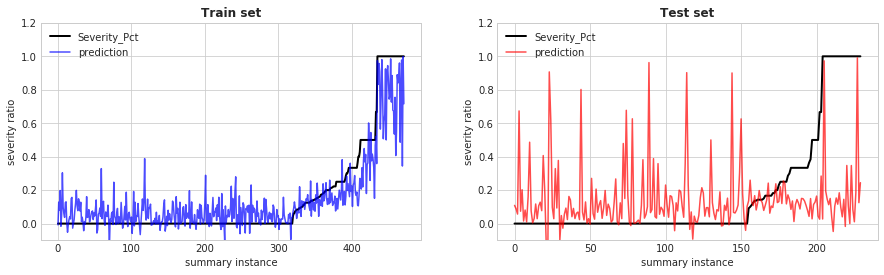

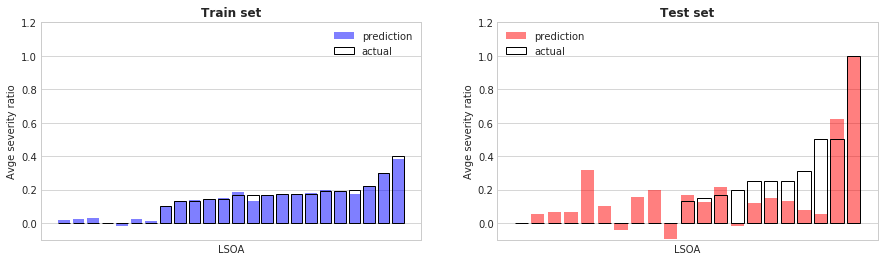

In [315]:
features={
    'response':'Severity_Pct',
    'cat_pred': ['Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions',\
            'Day_of_Week', 'LSOA_of_Accident_Location', 'Peak_or_OffPeak'],\
    'ord_pred':['Centroid_Latitude', 'Centroid_Longitude']}

data_group={
    'name': "Police_Force",
    'item': "City of London"}

rdd_train_norm, rdd_test_norm, ml_feats= load_one_hot_and_split_data_with_centroids(data_group, features)
rdd_train_norm.cache()
rdd_test_norm.cache()
pipeline_norm, model_gbt_norm = create_and_train_gbt_model_normalised(rdd_train_norm, ml_feats)
pred_train_norm = evaluate_reg_model(model_gbt_norm, rdd_train_norm, "train", response=ml_feats["response"])
pred_test_norm = evaluate_reg_model(model_gbt_norm, rdd_test_norm, "test", response=ml_feats["response"])
display_results_graphs(pred_train_norm, pred_test_norm)
display_agg_results_graphs(pred_train_norm, pred_test_norm)
rdd_train_norm.unpersist()
rdd_test_norm.unpersist()

<b>Using LSOA centroids GPS data as ordinal feature instead of LSOA designation as a categorical feature improves performance.<br>
Let's use a cross-validated grid search to see if we can improve further</b>

## Grid Search to optimize model parameters

In [310]:
def run_grid_search(rdd_data, pipeline, response=features["response"], maxDepth=[4, 6, 10], maxBins=[60, 100], maxIter=[40, 60]):
    gbt = pipeline.getStages()[-1]
    paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, maxDepth)
             .addGrid(gbt.maxBins, maxBins)
             .addGrid(gbt.maxIter, maxIter)
             .build())
    evaluator = RegressionEvaluator(labelCol=response, predictionCol="prediction", metricName="rmse")
    cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
    start_time = time.time()
    cvModel = cv.fit(rdd_data)
    print("Grid search completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return cvModel


def get_best_model(cvModel):
    return cvModel.bestModel


def get_best_model_params(cvModel):
    best_gbt_params = {"MaxDepth": cvModel.bestModel.stages[-1]._java_obj.getMaxDepth(),
    "maxBins": cvModel.bestModel.stages[-1]._java_obj.getMaxBins(),
    "maxIter": cvModel.bestModel.stages[-1]._java_obj.getMaxIter()}
    print("Best GBT parameters found: {}".format(best_gbt_params))
    return best_gbt_params


In [311]:
#Run grid search with standard evaluator
rdd_train_norm.cache()
cvModel_norm = run_grid_search(rdd_train_norm, pipeline_norm, response=ml_feats["response"], 
                                      maxDepth=[4, 6], maxBins=[50, 100], maxIter=[40])

Grid search completed  - Processing time: 3049 secs


Best model metrics:
Best GBT parameters found: {'maxBins': 50, 'maxIter': 40, 'MaxDepth': 4}
Root Mean Squared Error (RMSE) on train data = 0.20
evaluation completed  - Processing time: 41 secs
Root Mean Squared Error (RMSE) on test data = 0.35
evaluation completed  - Processing time: 4 secs
train set size=472, test set size=230


DataFrame[Weather_Conditions_index_vec: vector, Light_Conditions_index_vec: vector, Road_Surface_Conditions_index_vec: vector, Day_of_Week_index_vec: vector, Peak_or_OffPeak_index_vec: vector, Centroid_Latitude: double, Centroid_Longitude: double, Slight: bigint, Serious: bigint, Severity_Pct: double]

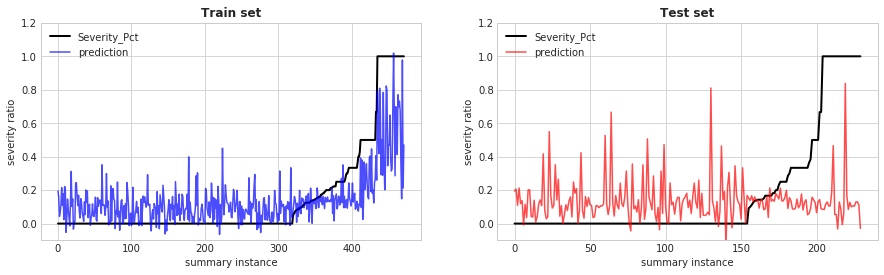

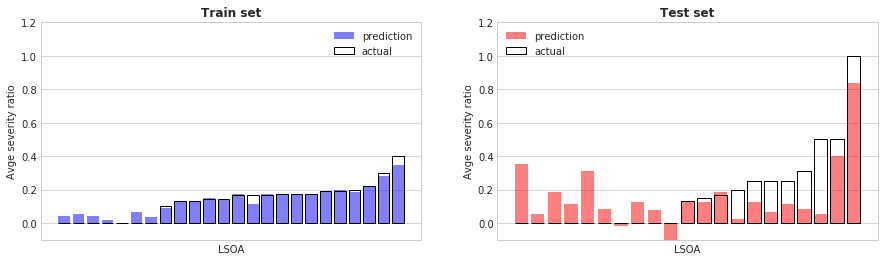

In [316]:
print("Best model metrics:")
best_gbt = get_best_model(cvModel_norm)
best_gbt_params = get_best_model_params(cvModel_norm)
rdd_test_norm.cache()
pred_train_norm = evaluate_reg_model(best_gbt, rdd_train_norm, "train", response=ml_feats["response"])
pred_test_norm = evaluate_reg_model(best_gbt, rdd_test_norm, "test", response=ml_feats["response"])
display_results_graphs(pred_train_norm, pred_test_norm)
display_agg_results_graphs(pred_train_norm, pred_test_norm)
rdd_train_norm.unpersist()
rdd_test_norm.unpersist()

In [ ]:
#longer grid search (to be done)
rdd_train_norm.cache()
cvModel_norm = run_grid_search(rdd_train_norm, pipeline_norm, response=ml_feats["response"], 
                                      maxDepth=[4, 6,10], maxBins=[50, 100], maxIter=[30,40,50])

# Deep Models using Keras

In [65]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import Callback
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import MinMaxScaler as MinMax
from keras.utils import np_utils


Using TensorFlow backend.


In [290]:
#repeat some global variables

features={
    'response':'Severity_Pct',
    'cat_pred': ['Weather_Conditions', 'Light_Conditions', 'Road_Surface_Conditions',\
            'Day_of_Week', 'LSOA_of_Accident_Location', 'Peak_or_OffPeak']}
data_group={
    'name': "Police_Force",
    'item': "City of London"}

response='Severity_Pct'


def local_load_one_hot_and_split_data(group=data_group, features=features, centroids=False):
    #main data transformation function for the deep models:
    #Generate train and test sets as Pandas dataframes 
    #because we are running Keras locally and not on the distributed Spark cluster.
    #The aggregation procedure is adapted accordingly
    #Centroids features are added or not to test their impacts on performance
    #The main difficulty here is to perform all the required transformations (scaling, encoding) on the full
    #dataset, then split into train/test then finally summarize as the last step
    #This is to ensure that the data is encoded consistently between the two sets
    start_time = time.time()
    rdd_data = load_data(group=group)
    new_features={}
    new_features['response'] = 'Severity_Pct'
    new_features['cat_pred'] = features['cat_pred']
    #separate lsoa vs centroids
    if centroids:
        sql_query = ''' 
            SELECT 
            LSOA_of_Accident_Location, COUNT(LSOA_of_Accident_Location) As Accident_Count,
            PERCENTILE(Latitude, 0.5) AS Centroid_Latitude, 
            PERCENTILE(Longitude, 0.5) AS Centroid_Longitude 
            FROM accidents 
            GROUP BY LSOA_of_Accident_Location'''
        lsoa_data = spark.sql(sql_query)
        rdd_data = rdd_data.join(lsoa_data, rdd_data.LSOA_of_Accident_Location == lsoa_data.LSOA_of_Accident_Location)\
        .drop(lsoa_data.LSOA_of_Accident_Location).drop(lsoa_data.Accident_Count)
        #remove null values
        rdd_data = rdd_data.select([to_null(c).alias(c) for c in rdd_data.columns]).na.drop()
        #add centroids in feature list
        new_features['ord_pred'] = ['Centroid_Latitude', 'Centroid_Longitude']
    else:
        new_features['ord_pred']=[]
    dataset = rdd_data.toPandas()
    if centroids:
        #scale lat/lon data into [0,1]
        scaler = MinMax()
        columns = ['Centroid_Latitude', 'Centroid_Longitude']
        dataset[columns] = scaler.fit_transform(dataset[columns])
    #one_hot encode categorical data
    #list all possible lsoas in dataset
    lsoa_cat = list(set(dataset['LSOA_of_Accident_Location'].values))
    #remove LSOA_of_Accident_Location from feature list before performing get_dummies
    if 'LSOA_of_Accident_Location' in new_features['cat_pred']: 
        new_features['cat_pred'].remove('LSOA_of_Accident_Location')
    dataset = pd.get_dummies(dataset, columns=new_features['cat_pred']+['Accident_Severity'])
    #split before summarising - how to ensure that one hot encoding of lsoa is consistent????
    data_train, data_test = train_test_split(dataset, test_size=0.2, random_state=rnd_seed)
    data_train = summarize_dataset_by_lsoa(data_train, lsoa_cat, centroids)
    data_test = summarize_dataset_by_lsoa(data_test, lsoa_cat, centroids)
    assert (data_train.columns==data_test.columns).all()
    all_pred = [x for x in data_train.columns if x != 'Severity_Pct']
    print("loading completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return data_train, data_test, all_pred

                             
                             
def summarize_dataset_by_lsoa(dataset, lsoa_cat, centroids):
    #summarize adapted to Pandas get_dummies: we explicitely specifiy the encoding form LSOAs
    #so that the encoding is the same on train and test set
    dummy_severity =['Accident_Severity_Serious','Accident_Severity_Slight']
    to_remove = ['Accident_Severity', 'Police_Force', 'Latitude','Longitude','Hour','Week'] + dummy_severity
    to_remove = to_remove + (['LSOA_of_Accident_Location'] if centroids else [])
    features_kept = [x for x in list(dataset.columns.values) if x not in to_remove]
    df = dataset.groupby(features_kept)[dummy_severity].apply(lambda x : x.astype(int).sum()).reset_index()
    df['Severity_Pct'] = df['Accident_Severity_Serious']/(df['Accident_Severity_Serious']+df['Accident_Severity_Slight'])
    df = df.drop(dummy_severity, axis=1)
    if 'LSOA_of_Accident_Location' in df.columns:
        #cast lsoa column as categorical - this ensures that get_dummies will be consistent when applied after train/test split
        df['LSOA_of_Accident_Location'] = df['LSOA_of_Accident_Location'].astype("category", categories=lsoa_cat)
        df = pd.get_dummies(df, columns=['LSOA_of_Accident_Location'])
    return df

                             

def display_local_results_graphs(df1, df2):
    #same as the GBT model 
    fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    df1 = df1.sort_values('Severity_Pct')
    df1.plot(y='Severity_Pct', ax=ax1, use_index=False, c='k', linewidth=2)
    df1.plot(y='prediction', ax=ax1, use_index=False, c='b', alpha=0.7)
    ax1.set_title("Train set", fontweight='bold')
    ax1.set_ylim(-.1, 1.2)
    ax1.set_xlabel("summary instance")
    ax1.set_ylabel("severity ratio")
    df2 = df2.sort_values('Severity_Pct')
    df2.plot(y='Severity_Pct', ax=ax2, use_index=False, c='k', linewidth=2)
    df2.plot(y='prediction', ax=ax2, use_index=False,c='r', alpha=0.7)
    ax2.set_title("Test set", fontweight='bold')
    ax2.set_ylim(-.1, 1.2)
    ax2.set_xlabel("summary instance")
    ax2.set_ylabel("severity ratio")    
    print("train set size={:d}, test set size={:d}".format(len(df1), len(df2)))
    return


## Initial results
We train a small and a larger model for comparison

In [273]:
import tensorflow as tf
from keras import backend as K
from keras.callbacks import Callback


# create model
def create_small_nn_model():
    model = Sequential()
    model.add(Dense(32, input_dim=len(all_pred), kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(8, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(4, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    print(model.summary())
    return model


def create_large_nn_model():
    model = Sequential()
    model.add(Dense(128, input_dim=len(all_pred), kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.1))
    model.add(Dense(16, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    print(model.summary())
    return model 

def root_mean_squared_error(y_true, y_pred):
    #custom rmse measure for history plots
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

    

class LossHistory(Callback):
    #used to store train and val losses during trainnig for display later
    def on_train_begin(self, logs={}):
        self.counter = 0
        self.losses = []
        #self.train_loss = []
        self.val_loss = []
        
    def on_train_end(self, logs={}):
        print()
        return
    def on_epoch_end(self, batch, logs={}):
        self.counter += 1
        self.losses.append(logs.get('loss'))
        y_pred = self.model.predict(self.validation_data[0])
        val_loss = root_mean_squared_error(self.validation_data[1], y_pred)
        self.val_loss.append(K.eval(val_loss))
        sys.stdout.write('\r epoch:{:d}, current loss={:0.3f}, val_loss={:0.3f}'.\
                         format(self.counter, logs.get('loss'),K.eval(val_loss)))
        sys.stdout.flush()       

        
def nn_model_compile_and_train(model, X_train, Y_train, batch_size=128, epochs=300):
    # Compile model, train and display learning curves
    start_time = time.time()
    lr = LossHistory()
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=[root_mean_squared_error])
    history = model.fit(X_train, Y_train, validation_split = 0.2, epochs=epochs, batch_size=batch_size, 
                        verbose=0, shuffle=True, callbacks=[lr])
    print("Training time: {:0.0f} secs".format(time.time() - start_time))
    # list all data in history
    plot_learning_curves(history, lr)
    return model, lr


def plot_learning_curves(history, lr):
    # summarize history 
    fig, ax1 =plt.subplots(nrows=1, ncols=1, figsize=(10,5))
    ax1.plot([np.sqrt(x) for x in history.history['loss']], alpha=0.8, linewidth=4, c='b')
    ax1.plot([np.sqrt(x) for x in history.history['val_loss']],alpha=0.8, linewidth=4, c='r')
    #ax1.plot(lr.train_aucs,'b:', alpha=0.8, linewidth=4)
    ax1.plot(lr.val_loss,'r:', alpha=0.8, linewidth=4)
    ax1.set_title('model RMSE')
    ax1.set_ylabel('rmse')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'val', 'train_calc', 'val_calc'], loc='upper left')
    return



def evaluate_nn_model(model, dataset, set_name):
    #Calculate rmse performance measure
    start_time = time.time()
    X = dataset[all_pred].values
    Y = dataset[response].values
    predY  = model.predict(X)
    dataset['prediction'] = predY
    rmse = np.sqrt(mean_squared_error(Y, predY))
    print("Root Mean Squared Error (RMSE) on {} data = {:.2f}".format(set_name, rmse)) 
    print("evaluation completed  - Processing time: {:0.0f} secs".format(time.time() - start_time))
    return dataset, predY

In [294]:
#Load data
data_train, data_test, all_pred = local_load_one_hot_and_split_data(group=data_group, features=features, centroids=False)

Row(Accident_Severity='Serious', LSOA_of_Accident_Location='E01000004', Police_Force='City of London', Latitude=51.509528, Longitude=-0.079251, Weather_Conditions='Fine no high winds', Light_Conditions='Daylight', Road_Surface_Conditions='Wet or damp', Day_of_Week='Tuesday', Hour=6, Week=1, Peak_or_OffPeak='OffPeak')
nb Slight:3481, nb Serious:589, %Slight: 85.5%
loading completed  - Processing time: 3 secs


/usr/local/src/conda3_runtime/home/envs/DSX-Python35-Spark/lib/python3.5/site-packages/ipykernel/__main__.py:97: FutureWarning: specifying 'categories' or 'ordered' in .astype() is deprecated; pass a CategoricalDtype instead


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_131 (Dense)            (None, 32)                1632      
_________________________________________________________________
dropout_79 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_132 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_80 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_133 (Dense)            (None, 8)                 136       
_________________________________________________________________
dropout_81 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_134 (Dense)            (None, 4)                 36        
__________

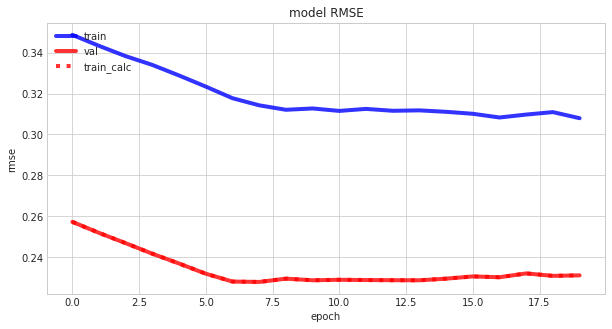

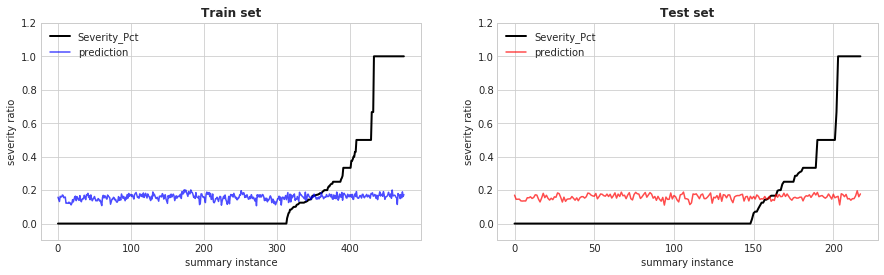

In [295]:
small_nn_model = create_small_nn_model()
small_nn_model ,lr = nn_model_compile_and_train(small_nn_model, 
                data_train[all_pred].values, data_train[response], batch_size=32, epochs=20)    
data_train, nn_pred_train = evaluate_nn_model(small_nn_model, data_train,  "train")
data_test, nn_pred_test = evaluate_nn_model(small_nn_model, data_test, "test")
display_local_results_graphs(data_train, data_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_136 (Dense)            (None, 128)               6528      
_________________________________________________________________
dropout_82 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_137 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_83 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_138 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_84 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_139 (Dense)            (None, 16)                528       
__________

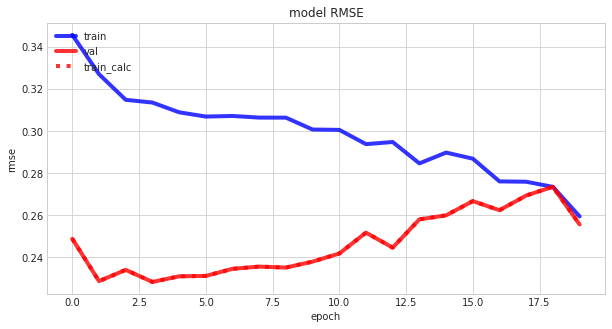

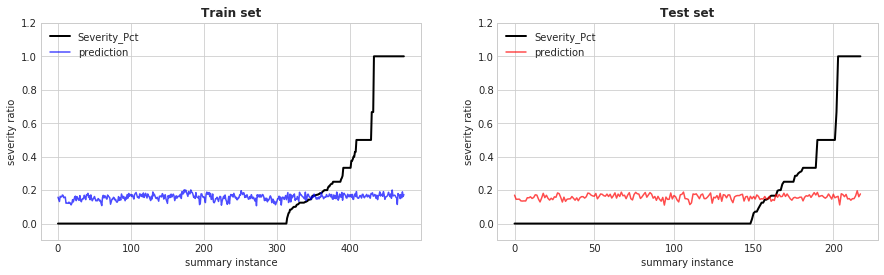

In [296]:
large_nn_model = create_large_nn_model()
large_nn_model ,lr = nn_model_compile_and_train(large_nn_model, 
                data_train[all_pred].values, data_train[response], batch_size=32, epochs=20)    
data_train, nn_pred_train = evaluate_nn_model(small_nn_model, data_train,  "train")
data_test, nn_pred_test = evaluate_nn_model(small_nn_model, data_test, "test")
display_local_results_graphs(data_train, data_test)

<b>Both the small and the large deep network have better rmse metrics than the GBT regressor <br>
but cannot capture the real dynamics of the dataset. They just find the best average</b>

## Additional feature transformation: Replace categorical LSOA with continuous Lat/Lon Centroids - normalised

In [297]:
#Load the dataa
data_train, data_test, all_pred = local_load_one_hot_and_split_data(group=data_group, features=features, centroids=True)

Row(Accident_Severity='Serious', LSOA_of_Accident_Location='E01000004', Police_Force='City of London', Latitude=51.509528, Longitude=-0.079251, Weather_Conditions='Fine no high winds', Light_Conditions='Daylight', Road_Surface_Conditions='Wet or damp', Day_of_Week='Tuesday', Hour=6, Week=1, Peak_or_OffPeak='OffPeak')
nb Slight:3481, nb Serious:589, %Slight: 85.5%
loading completed  - Processing time: 40 secs


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_151 (Dense)            (None, 32)                864       
_________________________________________________________________
dropout_91 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_152 (Dense)            (None, 16)                528       
_________________________________________________________________
dropout_92 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_153 (Dense)            (None, 8)                 136       
_________________________________________________________________
dropout_93 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_154 (Dense)            (None, 4)                 36        
__________

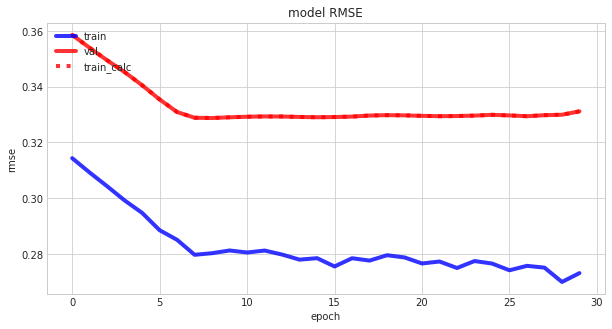

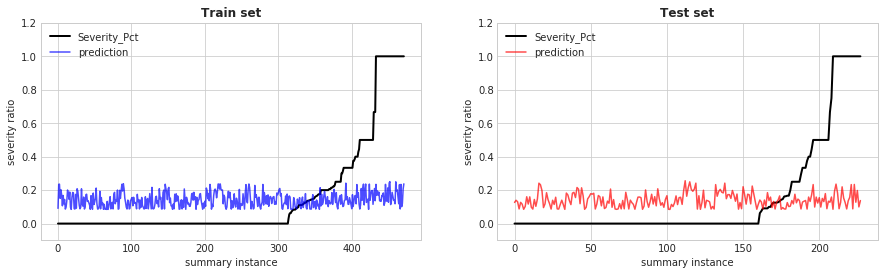

In [300]:
small_nn_model = create_small_nn_model()
small_nn_model ,lr = nn_model_compile_and_train(small_nn_model, 
                data_train[all_pred].values, data_train[response], batch_size=32, epochs=30)    
data_train, nn_pred_train = evaluate_nn_model(small_nn_model, data_train,  "train")
data_test, nn_pred_test = evaluate_nn_model(small_nn_model, data_test, "test")
display_local_results_graphs(data_train, data_test)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_146 (Dense)            (None, 128)               3456      
_________________________________________________________________
dropout_88 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_147 (Dense)            (None, 64)                8256      
_________________________________________________________________
dropout_89 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_148 (Dense)            (None, 32)                2080      
_________________________________________________________________
dropout_90 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_149 (Dense)            (None, 16)                528       
__________

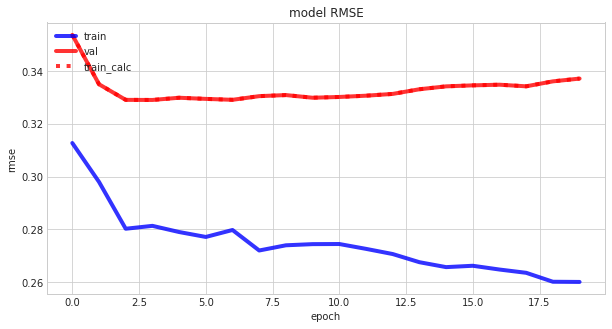

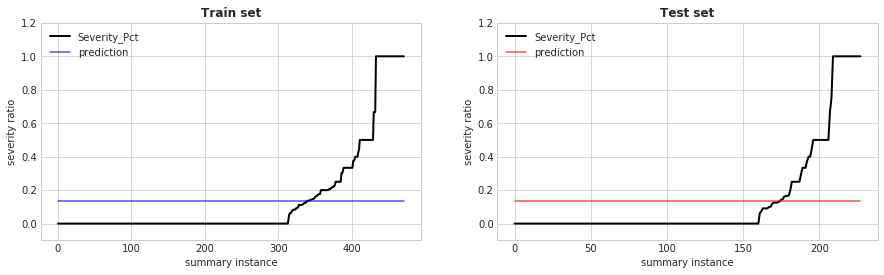

In [299]:
large_nn_model = create_large_nn_model()
large_nn_model ,lr = nn_model_compile_and_train(large_nn_model, 
                data_train[all_pred].values, data_train[response], batch_size=32, epochs=30)    
data_train, nn_pred_train = evaluate_nn_model(small_nn_model, data_train,  "train")
data_test, nn_pred_test = evaluate_nn_model(small_nn_model, data_test, "test")
display_local_results_graphs(data_train, data_test)

<b>With the new normalilsed and continuous feature performance is similar but with much less variance</b>